In [1]:
import uproot
import subprocess
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick

In [2]:
ar_raw = uproot.concatenate([f"root://eos.grif.fr//eos/grif/cms/llr/store/user/tcuisset/GluGluToXToZZTo2B2Tau_M-5000_TuneCP5_13TeV-powheg-pythia8/crab_test_2/240912_102034/0000/NANO_NANO_{i}.root:Events" for i in [1, 3, 4, 6, 7, 8, 9, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22]],
    filter_name=["boostedTau*", "Muon_*", "Electron_*", "GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_eta", "GenPart_phi", "GenPart_pt", "nGenVisTau", "GenVisTau*"],
    how="zip")

In [4]:
ak.max(ar_raw.boostedTau.Mcounter)

4

In [55]:
def genPairType_branch(ar):
    """ select etau, mutau, tautau at genlevel"""
    tautau = ar.nGenVisTau == 2

    mutau_genMuon_bool = (abs(ar.GenPart.pdgId) == 13) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    mutau_genMuon_idx = ak.firsts(ak.local_index(ar.GenPart)[mutau_genMuon_bool]) # index of gen muon in GenPart collection
    mutau = (ar.nGenVisTau == 1) & ak.any(mutau_genMuon_bool, axis=-1)
    
    etau_genMuon_bool = (abs(ar.GenPart.pdgId) == 11) & (abs(ar.GenPart[ar.GenPart.genPartIdxMother].pdgId) == 15)
    etau_genMuon_idx = ak.firsts(ak.local_index(ar.GenPart)[etau_genMuon_bool]) # index of gen muon in GenPart collection
    etau = (ar.nGenVisTau == 1) & ak.any(etau_genMuon_bool, axis=-1)
    
    genPairType =  ak.where(mutau, 0, ak.where(etau, 1, ak.where(tautau, 2, -1)))
    genLeptonIdx = ak.where(mutau, mutau_genMuon_idx, etau_genMuon_idx) # for tautau will just put None
    return ak.with_field(ak.with_field(ar, genPairType, where="genPairType"), genLeptonIdx, "genLeptonIdx")
def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)

def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)

class DotDict(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
deeptau=DotDict(
    vsjet=DotDict(VVVLoose=1, VVLoose=2, VLoose=3, Loose=4, Medium=5,
        Tight=6, VTight=7, VVTight=8),
    vse=DotDict(VVVLoose=1, VVLoose=2, VLoose=3, Loose=4, Medium=5,
        Tight=6, VTight=7, VVTight=8),
    vsmu=DotDict(VLoose=1, Loose=1, Medium=3, Tight=4),
)


def match_muon_gen(ar):
    """ Match muon to gen """
    gen_muons = ak.firsts(ar.GenPart[ak.singletons(ar.genLeptonIdx)])
    matched = (delta_r(gen_muons.eta, gen_muons.phi, ar.Muon.eta, ar.Muon.phi) < 0.1)
    return ak.firsts(ar.Muon[matched])

def match_boostedtau_gen(ar):
    """ Match boostedtau to gen """
    gen_taus = ak.firsts(ar.GenVisTau)
    matched = (delta_r(gen_taus.eta, gen_taus.phi, ar.boostedTau.eta, ar.boostedTau.phi) < 0.4)
    return ak.firsts(ar.boostedTau[matched])


In [14]:
ar = genPairType_branch(ar_raw)
ar

<Array [{nGenVisTau: 0, ...}, ..., {...}] type='70000 * {nGenVisTau: int32,...'>

In [15]:
ar_mu = ar[ar.genPairType == 0]
ar_mu

<Array [{nGenVisTau: 1, ...}, ..., {...}] type='15399 * {nGenVisTau: int32,...'>

In [68]:
effs = defaultdict(dict)

matched_boostedtaus = match_boostedtau_gen(ar_mu)
cut = ~ak.is_none(matched_boostedtaus)
effs["Reco boostedTau genmatched"] = eff(cut, ar_mu)


cut = cut & (matched_boostedtaus.LeadingMuonPt > 0)
effs["Reco muon"] = eff(cut, ar_mu)

effs

defaultdict(dict,
            {'Reco boostedTau genmatched': 0.9676602376777713,
             'Reco muon': 0.5473732060523411})

In [78]:
ak.drop_none(matched_boostedtaus[matched_boostedtaus.LeadingMuonPt > 0].LeadingMuonCorrIso / matched_boostedtaus[matched_boostedtaus.LeadingMuonPt > 0].LeadingMuonPt)

<Array [2.62, 0.0453, 3.33, 0.34, ..., 7.88, 4.24, 1.39] type='8429 * float32'>

/opt/exp_soft/llr/python/3.11.8/el7/lib/python3.11/site-packages/mplhep/plot.py:592: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks)


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f0c8f175090>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

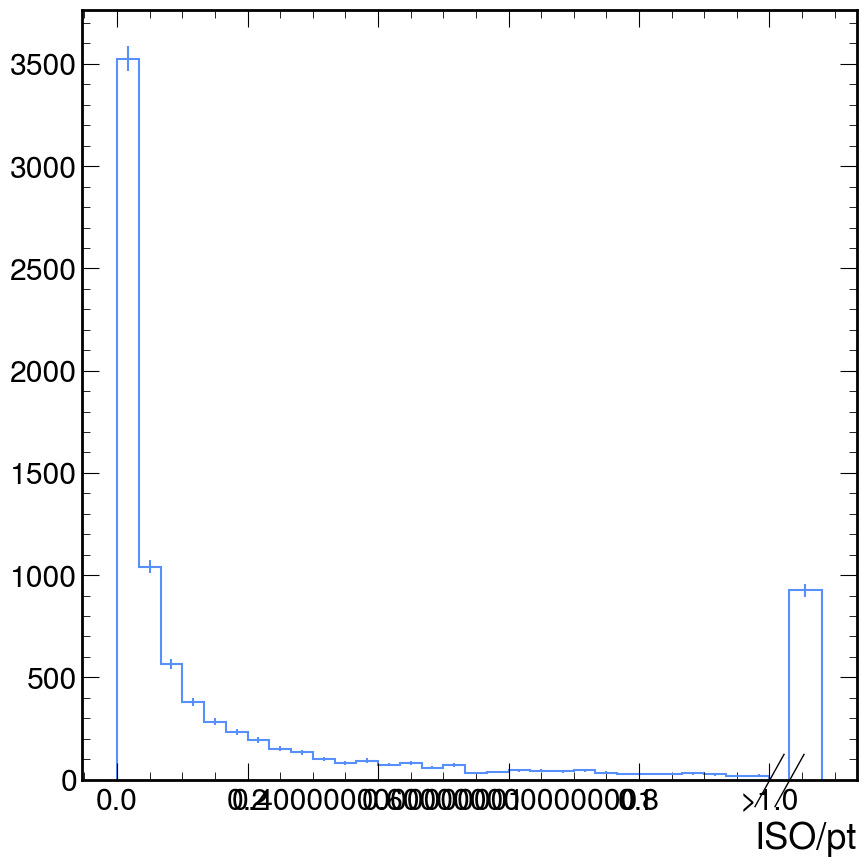

In [79]:
h_iso = hist.Hist(hist.axis.Regular(30, 0., 1., name="ISO/pt", underflow=False, overflow=True))
h_iso.fill(ak.drop_none(matched_boostedtaus[matched_boostedtaus.LeadingMuonPt > 0].LeadingMuonCorrIso / matched_boostedtaus[matched_boostedtaus.LeadingMuonPt > 0].LeadingMuonPt))
hep.histplot(h_iso, flow="show")

In [67]:
matched_boostedtaus.LeadingMuonPt

<Array [-1, -1, 75.8, -1, ..., 56.4, 58.4, -1, 222] type='15399 * ?float32'>

In [27]:
ar_mu.genLeptonIdx

<Array [33, 34, 43, 37, 34, 49, ..., 29, 42, 37, 52, 63] type='15399 * ?int64'>

In [34]:
ar_mu.boostedTau

<Array [[{idAntiEle2018: 5, ...}, ...], ...] type='15399 * var * {idAntiEle...'>

In [31]:
ar_mu.GenPart[0, 33]

<Record {genPartIdxMother: 17, pdgId: 13, ...} type='{genPartIdxMother: int...'>

In [57]:
ar_mu.GenVisTau[0][["eta", "phi", "pt"]]

<Array [{eta: 1.17, phi: -0.366, pt: 594}] type='1 * {eta: float32, phi: fl...'>

In [60]:
ar_mu.boostedTau[0][["pt", "eta", "phi", "LeadingMuondelR", "LeadingMuonPt", "LeadingMuonCorrIso"]]

<Array [{pt: 425, eta: -0.664, ...}, ...] type='3 * {pt: float32, eta: floa...'>

In [50]:
ar_mu.boostedTau[2, 1][["pt", "eta", "phi", "LeadingMuondelR", "LeadingMuonPt", "LeadingMuonCorrIso"]]

<Record {pt: 435, eta: -0.397, phi: -0.469, ...} type='{pt: float32, eta: f...'>

In [52]:
199/435

0.4574712643678161

In [51]:
ar_mu.Muon[2][["eta", "pt", "phi"]]

<Array [{eta: 1.14, pt: 679, ...}, ..., {...}] type='4 * {eta: float32, pt:...'>